# Regression Neural Network with Adam optimization and mini-batches

The following project implements a neural network to predict a quantitative measure of diabetes progression. For context:

- Dataset used: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset
- Activation function for output layer: None (since this is a regression problem, the output layer can be linear regression)
- Activation function for hidden layers: ReLU
- Cost function: calculated using Mean Squared Error (MSE)
- Optimization method: Adam (gradient descent + momentum + RMSprop) + mini batches

In [2]:
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data preparation

- Import data
- Process the data (e.g., standardize features, reshape arrays)
- Split data into training set and testing set

In [3]:
dataset = sklearn.datasets.load_diabetes()

# Flatten 8x8 features per digit
X = dataset.data.reshape(dataset.data.shape[0],-1)

# Standardize feature values
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Convert target to binary since we are only interested in classifying 5 versus not 5
Y = dataset.target.reshape((dataset.target.shape[0],1))

# Split data into training and testing
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.3,random_state=11)

X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
print("Shape of X_train:",X_train.shape)
print("Shape of Y_train:",Y_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of Y_test:",Y_test.shape)

Shape of X_train: (10, 309)
Shape of Y_train: (1, 309)
Shape of X_test: (10, 133)
Shape of Y_test: (1, 133)


## Mini-batch creation

In [4]:
def create_mini_batches(X:np.ndarray, Y:np.ndarray, mini_batch_size:int, seed:int) -> list:
    """
    Create mini-batches from the data.
    
    Parameters:
    - X: Training data
    - y: Target values
    - mini_batch_size: Desired mini-batch size
    - seed: Integer used to randomize the shuffling

    Returns:
    List of mini-batches
    """
    np.random.seed(seed) # To randomize shuffling
    m = X.shape[1]  # Number of training examples

    # Shuffle the data
    permutations = list(np.random.permutation(m))
    X_shuffled = X[:,permutations]
    Y_shuffled = Y[:,permutations].reshape((1, m))

    # Partition
    mini_batches = []
    num_complete_batches = m // mini_batch_size  # Number of complete batches
    
    for i in range(num_complete_batches):
        mini_batch_X = X_shuffled[:, i * mini_batch_size : (i + 1) * mini_batch_size]
        mini_batch_y = Y_shuffled[:, i * mini_batch_size : (i + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_y))
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X_shuffled[:, num_complete_batches * mini_batch_size :]
        mini_batch_y = Y_shuffled[:, num_complete_batches * mini_batch_size :]
        mini_batches.append((mini_batch_X, mini_batch_y))
    
    return mini_batches

## Model building blocks

- Initialize parameters
- Initialize Adam parameters
- Forward propagation
- Compute cost
- Backward propagation
- Update parameters (including Adam parameters)

In [5]:
def initialize_parameters(layer_dimensions:list) -> dict:
    """
    Initializes parameters (weights and biases) for a neural network of given dimensions.

    Arguments:
    ---
    - layer_dimensions: list containing the dimensions of each layer in the network

    Returns:
    ---
    - parameters: dictionary containing parameters "W1", "b1", ..., "WL", "bL":
        - Wl: weight matrix of shape (layer_dims[l], layer_dims[l-1])
        - bl: bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dimensions)

    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01
        parameters[f"b{l}"] = np.zeros((layer_dimensions[l], 1))

    return parameters

In [6]:
def initialize_adam(parameters:dict) -> tuple[dict,dict]:
    """
    Initializes Adam optimizer parameters v and s as two dictionaries.
    
    Arguments:
    ---
    - parameters: dictionary containing parameters "W1", "b1", ..., "WL", "bL":
        - Wl: weight matrix of shape (layer_dims[l], layer_dims[l-1])
        - bl: bias vector of shape (layer_dims[l], 1)
    
    Returns:
    ---
    - v: dictionary containing the exponentially weighted average of the gradient. Initialized with zeros.
    - s: dictionary containing the exponentially weighted average of the squared gradient. Initialized with zeros.
    """
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(1, L + 1):
        v[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        v[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)
        s[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        s[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)

    return v, s

In [7]:
def relu(z:np.ndarray) -> np.ndarray:
    return np.maximum(0, z)

def forward_propagation(X:np.ndarray, parameters:dict) -> tuple[np.ndarray,list]:
    """
    Propagates calculation forward across hidden layers (ReLU activation) and output layer (no activation).

    Arguments:
    ---
    - X: data, numpy array of shape (input size, number of examples)
    - parameters: dictionary containing parameters "W1", "b1", ..., "WL", "bL":
        - Wl: weight matrix of shape (layer_dims[l], layer_dims[l-1])
        - bl: bias vector of shape (layer_dims[l], 1)

    Returns:
    ---
    - ZL: value from the output layer (no activation)
    - caches: dictionary containing caches for every layer
    """
    caches = {}
    A = X
    L = len(parameters) // 2

    # Forward propagation for hidden layers (ReLU)
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        Z = np.dot(W,A_prev)+b
        A = relu(Z)
        caches[f"A{l-1}"] = A_prev
        caches[f"W{l}"] = W
        caches[f"b{l}"] = b
        caches[f"Z{l}"] = Z

    # Forward propagation for output layer (no activation)
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    ZL= np.dot(W,A)+b
    caches[f"A{L-1}"] = A
    caches[f"W{L}"] = W
    caches[f"b{L}"] = b
    caches[f"Z{L}"] = ZL

    return ZL, caches

In [8]:
def compute_cost(ZL:np.ndarray, Y:np.ndarray) -> float:
    """
    Computes the cost based on mean squared error.

    Arguments:
    ---
    - ZL: regression vector corresponding to predictions, shape (1, number of examples)
    - Y: true values vector, shape (1, number of examples)

    Returns:
    ---
    - cost: floating point number representing the cost
    """    
    m = Y.shape[1]

    cost = (1 / m) * np.sum((ZL - Y) ** 2)

    # Ensure cost is the dimension we expect (e.g., turns [[17]] into 17)
    cost = np.squeeze(cost)

    return cost

In [9]:
def relu_derivative(x):
    return (x > 0).astype(float)

def backward_propagation(ZL:np.ndarray, Y:np.ndarray, caches:dict) -> dict:
    """
    Propagates the calculation backwards across output layer (no activation) and hidden layers (ReLU activation).

    Arguments:
    ---
    - ZL: regression vector corresponding to predictions, shape (1, number of examples)
    - Y: true values vector, shape (1, number of examples)
    - caches: dictionary containing caches for every layer

    Returns:
    ---
    - gradients: dictionary containing gradients with respect to different parameters
    """
    gradients = {}
    L = len(caches) // 4
    m = ZL.shape[1]

    # Reshape Y to have the same shape as ZL
    Y = Y.reshape(ZL.shape)

    # Backward propagation for output layer (no activation)
    dZ = ZL - Y
    gradients[f"dW{L}"] = np.dot(dZ,caches[f"A{L-1}"].T)/m
    gradients[f"db{L}"] = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = dZ

    # Backward propagation for hidden layers (ReLU activation)
    for l in reversed(range(L-1)):
        dZ = dA_prev * relu_derivative(caches[f"Z{l+1}"])
        dA_prev = np.dot(caches[f"W{l+1}"].T,dZ)
        gradients[f"dW{l+1}"] = np.dot(dZ,caches[f"A{l}"].T)/m
        gradients[f"db{l+1}"] = np.sum(dZ,axis=1,keepdims=True)/m

    return gradients

In [10]:
def update_parameters_with_adam(
        parameters:dict,
        gradients:dict,
        v:dict,
        s:dict,
        t:int,
        learning_rate:float,
        beta1:float,
        beta2:float,
        epsilon:float
    ) -> tuple[dict,dict,dict]:
    """
    Update parameters using Adam optimization method.
    
    Arguments:
    ---
    - parameters: dictionary containing parameters:
        - parameters[f"W{l}"] = Wl
        - parameters[f"b{l}"] = bl
    - gradients: dictionary containing gradients for each parameter:
        - gradients[f"dW{l}"] = dWl
        - gradients[f"db{l}"] = dbl
    - v: Adam variable, moving average of the first gradient, python dictionary
    - s: Adam variable, moving average of the squared gradient, python dictionary
    - t: Adam variable, counts the number of taken steps
    - learning_rate: the learning rate, scalar
    - beta1: Exponential decay hyperparameter for the first moment estimates 
    - beta2: Exponential decay hyperparameter for the second moment estimates 
    - epsilon: hyperparameter preventing division by zero in Adam updates

    Returns:
    ---
    - parameters: dictionary containing parameters
    - v: Adam variable, moving average of the first gradient, python dictionary
    - s: Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients
        v[f"dW{l}"] = beta1*v[f"dW{l}"] + (1-beta1)*gradients['dW' + str(l)]
        v[f"db{l}"] = beta1*v[f"db{l}"] + (1-beta1)*gradients['db' + str(l)]
        
        # Compute bias-corrected first moment estimate
        v_corrected[f"dW{l}"] = v[f"dW{l}"]/(1-pow(beta1,t))
        v_corrected[f"db{l}"] = v[f"db{l}"]/(1-pow(beta1,t))

        # Moving average of the squared gradients
        s[f"dW{l}"] = beta2*s[f"dW{l}"] + (1-beta2)*np.square(gradients['dW' + str(l)])
        s[f"db{l}"] = beta2*s[f"db{l}"] + (1-beta2)*np.square(gradients['db' + str(l)])

        # Compute bias-corrected second raw moment estimate
        s_corrected[f"dW{l}"] = s[f"dW{l}"]/(1-pow(beta2,t))
        s_corrected[f"db{l}"] = s[f"db{l}"]/(1-pow(beta2,t))

        # Update parameters
        parameters[f"W{l}"] -= learning_rate*(v_corrected[f"dW{l}"]/(np.sqrt(s_corrected[f"dW{l}"])+epsilon))
        parameters[f"b{l}"] -= learning_rate*(v_corrected[f"db{l}"]/(np.sqrt(s_corrected[f"db{l}"])+epsilon))

    return parameters, v, s

## Model

In [11]:
def model(
    X:np.ndarray,
    Y:np.ndarray,
    layer_dimensions:list,
    learning_rate:float = 0.0007,
    mini_batch_size:int = 64,
    beta1:float = 0.9,
    beta2:float = 0.999,
    epsilon:float = 1e-8,
    num_epochs:int = 5000
    ) -> tuple[dict,list,list]:

    cost_per_iteration = []          # to keep track of the cost per iteration
    cost_per_epoch = []              # to keep track of the cost per epoch
    t = 0                            # Initialize counter required for Adam update
    seed = 1337                      # Initialize seed to randomize mini-batches

    # Initialize parameters
    parameters = initialize_parameters(layer_dimensions)

    # Initialize Adam parameters
    v, s = initialize_adam(parameters)

    # Optimization loop for each epoch
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = create_mini_batches(X, Y, mini_batch_size, seed)
        epoch_cost = 0

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            # Forward propagation
            ZL, caches = forward_propagation(minibatch_X, parameters)
            # Compute cost and add to the cost total
            cost = compute_cost(ZL, minibatch_Y)
            cost_per_iteration.append(cost)
            epoch_cost += cost
            # Backward propagation
            gradients = backward_propagation(ZL, minibatch_Y, caches)
            # Update Adam counter and update parameters
            t = t + 1
            parameters, v, s  = update_parameters_with_adam(parameters, gradients, v, s, t, learning_rate, beta1, beta2, epsilon)

        cost_per_epoch.append(epoch_cost)

    return parameters, cost_per_iteration, cost_per_epoch

In [12]:
def predict(X:np.ndarray, Y:np.ndarray, parameters:dict) -> np.ndarray:
    Y_predicted, _ = forward_propagation(X, parameters)
    print(f"Mean Absolute Error: {np.mean(np.abs(Y_predicted - Y))}")
    return Y_predicted

## Results

In [13]:
optimized_params, cost_per_iteration, cost_per_epoch = model(X_train,Y_train,layer_dimensions=[10,8,4,1])

### Learning curves

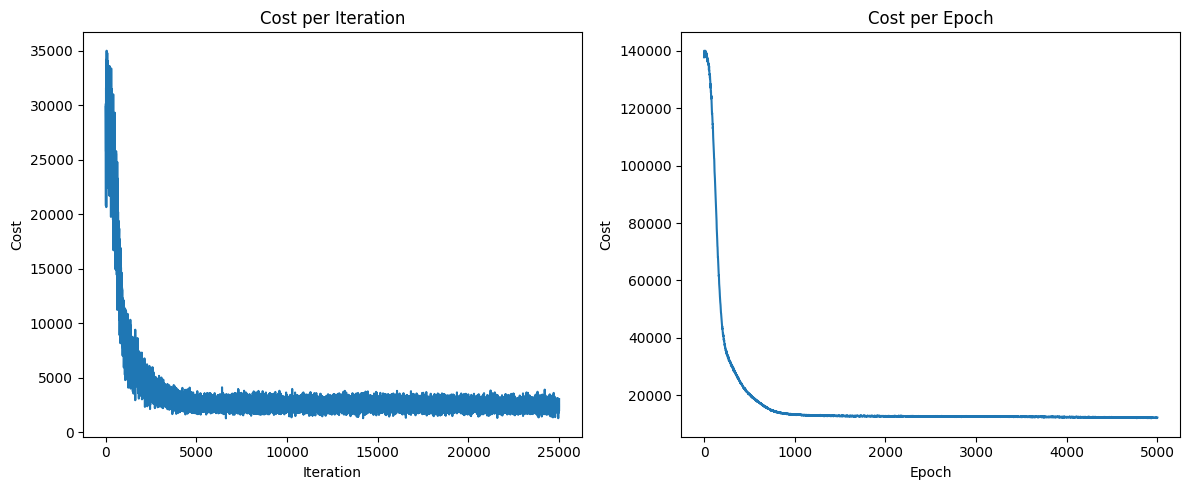

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(cost_per_iteration)
ax1.set_title('Cost per Iteration')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost')

ax2.plot(cost_per_epoch)
ax2.set_title('Cost per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cost')

# Display the plots
plt.tight_layout()
plt.show()

### Mean Absolute Error

In [16]:
Y_predicted_train = predict(X_train, Y_train, optimized_params)
Y_predicted_test = predict(X_test,Y_test,optimized_params)

Mean Absolute Error: 39.81631097231564
Mean Absolute Error: 45.588477449852725
